In [24]:
# import  libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Set plot style 
sns.set(style="whitegrid")

In [26]:
file_path = 'data_files/OnlineRetail.csv'

# Load the dataset
df = pd.read_csv(file_path, encoding='ISO-8859-1')

print("Data loaded successfully!")
print(df.head())

Data loaded successfully!
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [28]:
# Get basic information about the dataset
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [30]:
# 1. Drop rows where CustomerID is missing
df.dropna(subset=['CustomerID'], inplace=True)


In [32]:
# 2. Convert CustomerID to an integer
df['CustomerID'] = df['CustomerID'].astype(np.int64)

# 3. Remove returns (transactions with negative quantity)
df = df[df['Quantity'] > 0]

# 4. Convert InvoiceDate to datetime objects
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("\nData has been cleaned. Final shape:", df.shape)


Data has been cleaned. Final shape: (397924, 8)


In [34]:
# --- Create Cohort Metrics ---

# 1. Create 'InvoiceMonth' by trimming the date to the first day of the month
df['InvoiceMonth'] = df['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, 1))



In [36]:
# 2. Create 'CohortMonth' by finding the first purchase month for each customer
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')


In [38]:
# 3. Calculate 'CohortIndex' (the number of months since the first purchase)
def get_cohort_index(df, col1, col2):
    year1 = df[col1].dt.year
    year2 = df[col2].dt.year
    month1 = df[col1].dt.month
    month2 = df[col2].dt.month
    return (year1 - year2) * 12 + (month1 - month2) + 1

df['CohortIndex'] = get_cohort_index(df, 'InvoiceMonth', 'CohortMonth')

In [40]:
print("\nCreated cohort-specific columns.")
display(df[['CustomerID', 'InvoiceDate', 'InvoiceMonth', 'CohortMonth', 'CohortIndex']].head())


Created cohort-specific columns.


,CustomerID,InvoiceDate,InvoiceMonth,CohortMonth,CohortIndex
0,17850,2010-12-01 08:26:00,2010-12-01,2010-12-01,1
1,17850,2010-12-01 08:26:00,2010-12-01,2010-12-01,1
2,17850,2010-12-01 08:26:00,2010-12-01,2010-12-01,1
3,17850,2010-12-01 08:26:00,2010-12-01,2010-12-01,1
4,17850,2010-12-01 08:26:00,2010-12-01,2010-12-01,1


In [42]:
# Group data to count unique customers in each cohort over time
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

# Create a pivot table
cohort_counts = cohort_data.pivot_table(index='CohortMonth',
                                        columns='CohortIndex',
                                        values='CustomerID')

In [44]:
# Get the initial size of each cohort (Month 1)
cohort_sizes = cohort_counts.iloc[:, 0]

# Calculate the retention rate by dividing counts by the initial cohort size
cohort_retention = cohort_counts.divide(cohort_sizes, axis=0)

In [46]:
# Format as a percentage
cohort_retention = cohort_retention.round(3) * 100

print("\n--- Cohort Retention Matrix (%) ---")
display(cohort_retention)


--- Cohort Retention Matrix (%) ---


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='CohortIndex', ylabel='CohortMonth'>

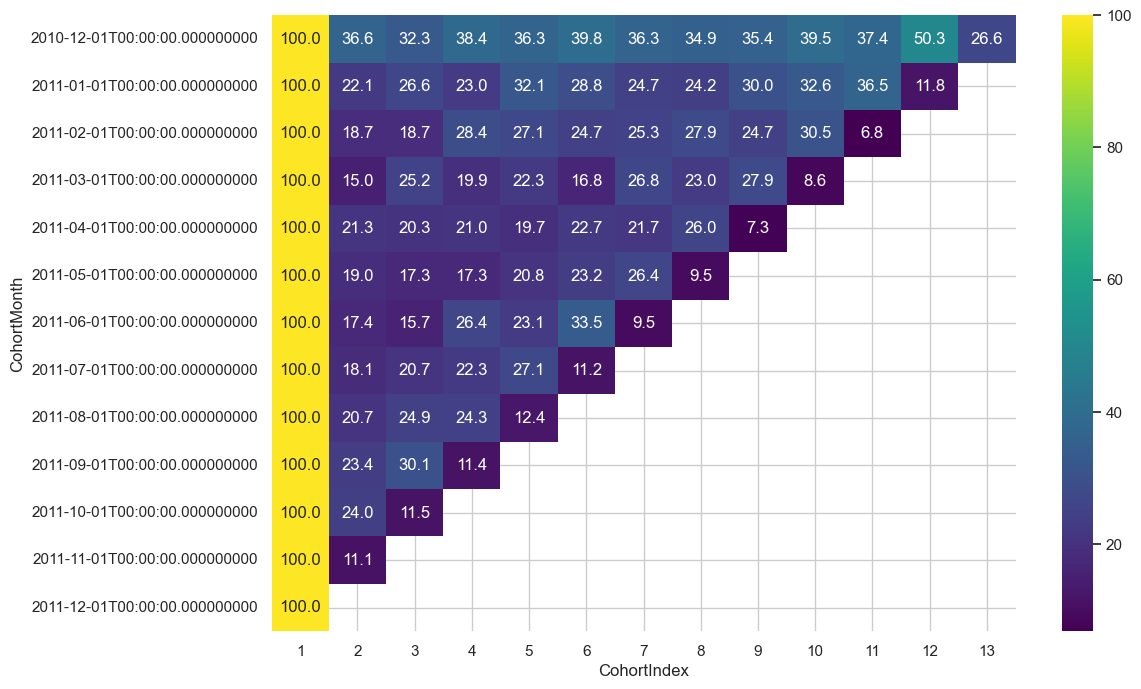

In [48]:
# Visualize the retention rates
plt.figure(figsize=(12, 8))
sns.heatmap(data=cohort_retention,
            annot=True,
            fmt='.1f', # Format to one decimal place
            cmap='viridis')

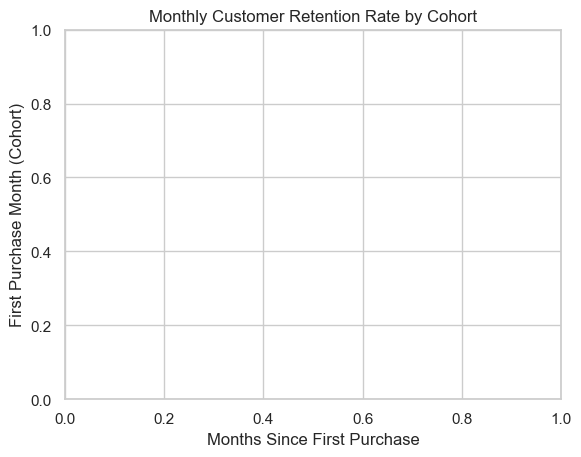

In [50]:
plt.title('Monthly Customer Retention Rate by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('First Purchase Month (Cohort)')
plt.show()